## Imports

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torchmetrics import Accuracy
import matplotlib.pyplot as plt

## Load dataset

In [3]:
df = pd.read_csv('Datasets/classification/Social_Network_Ads.csv')

In [4]:
df.head(2)

,User ID,Gender,Age,Estimated_Salary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0


In [5]:
df.dtypes

User ID              int64
Gender              object
Age                  int64
Estimated_Salary     int64
Purchased            int64
dtype: object

### convert object to category

In [6]:
df["Gender"] = df['Gender'].astype('category')
df.dtypes

User ID                int64
Gender              category
Age                    int64
Estimated_Salary       int64
Purchased              int64
dtype: object

## Preprocess

### Check and handle missing values

In [7]:
df.isnull().sum()

User ID             0
Gender              0
Age                 0
Estimated_Salary    0
Purchased           0
dtype: int64

### Encoding categorical feature

In [8]:
df.head()

,User ID,Gender,Age,Estimated_Salary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [9]:
cat_features = 'Gender'

le = LabelEncoder()
le.fit(df[cat_features].unique())
df[cat_features] = le.transform(df[cat_features])

In [10]:
df.head()

,User ID,Gender,Age,Estimated_Salary,Purchased
0,15624510,1,19,19000,0
1,15810944,1,35,20000,0
2,15668575,0,26,43000,0
3,15603246,0,27,57000,0
4,15804002,1,19,76000,0


## Train test split

In [11]:
x = df[['Gender', 'Age', 'Estimated_Salary']].values
y = df['Purchased'].values

In [12]:
type(x), type(y)

(numpy.ndarray, numpy.ndarray)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [14]:
x_train.shape

(320, 3)

In [15]:
y_train.shape

(320,)

In [16]:
x_test.shape

(80, 3)

## Standardization

In [17]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test =scaler.transform(x_test)

## Convert to tensor

In [18]:
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

In [19]:
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

## DataLoader

In [20]:
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

### Train loader

In [21]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

### Test loader

In [22]:
test_loader = DataLoader(test_set, batch_size=40)

### Get one batch

In [23]:
x, y = next(iter(train_loader))

In [24]:
x.shape, y

(torch.Size([32, 3]),
 tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
         0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.]))

## Device

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Model

In [26]:
class MLP(nn.Module):
    def __init__(self, in_feat, h1, h2, num_class):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_feat, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, num_class)
        self.Relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        out = self.fc1(x)
        out = self.Relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.Relu(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [27]:
# Define MLP model
model = MLP(in_feat=3, h1=32, h2=16, num_class=1)

In [28]:
model

MLP(
  (fc1): Linear(in_features=3, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (Relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.3, inplace=False)
)

## loss function & Optimizer 

In [29]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Utils

In [30]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## train loop

In [31]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    acc_train = Accuracy().to(device)
    loss_train = AverageMeter()
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(targets)
        
        # forward
        preds = model(inputs)
        
        # compute loss
        loss = criterion(preds, targets.unsqueeze(1))
       
        # backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_train.update(loss.item())
        acc_train(preds, targets.unsqueeze(1).int())
    
    model.eval()
    acc_valid = Accuracy().to(device)
    loss_valid = AverageMeter()
    
    with torch.no_grad():
        
        for i, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(device)
            targets = targets.to(targets)
            
            # forward
            preds = model(inputs)
            
            # compute loss
            criterion(preds, targets.unsqueeze(1))
            loss_valid.update(loss.item())
            
            acc_valid(preds, targets.unsqueeze(1).int())
            
    loss_train_hist.append(loss_train.avg)
    loss_valid_hist.append(loss_valid.avg)
    
    acc_train_hist.append(acc_train.compute())
    acc_valid_hist.append(acc_valid.compute())
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}')
        print(f'Train: loss = {loss_train.avg:.3}, Acc = {acc_train.compute():.3}')
        print(f'Valid: loss = {loss_valid.avg:.3}, Acc = {acc_valid.compute():.3}')
        print()

Epoch: 0
Train: loss = 0.669, Acc = 0.647
Valid: loss = 0.632, Acc = 0.65

Epoch: 10
Train: loss = 0.452, Acc = 0.803
Valid: loss = 0.458, Acc = 0.95

Epoch: 20
Train: loss = 0.349, Acc = 0.859
Valid: loss = 0.38, Acc = 0.925

Epoch: 30
Train: loss = 0.314, Acc = 0.887
Valid: loss = 0.255, Acc = 0.925

Epoch: 40
Train: loss = 0.287, Acc = 0.887
Valid: loss = 0.159, Acc = 0.925

Epoch: 50
Train: loss = 0.282, Acc = 0.913
Valid: loss = 0.174, Acc = 0.913

Epoch: 60
Train: loss = 0.281, Acc = 0.894
Valid: loss = 0.329, Acc = 0.925

Epoch: 70
Train: loss = 0.27, Acc = 0.9
Valid: loss = 0.151, Acc = 0.925

Epoch: 80
Train: loss = 0.26, Acc = 0.913
Valid: loss = 0.262, Acc = 0.925

Epoch: 90
Train: loss = 0.254, Acc = 0.906
Valid: loss = 0.252, Acc = 0.925

Epoch: 100
Train: loss = 0.281, Acc = 0.897
Valid: loss = 0.309, Acc = 0.925

Epoch: 110
Train: loss = 0.226, Acc = 0.916
Valid: loss = 0.218, Acc = 0.925

Epoch: 120
Train: loss = 0.237, Acc = 0.925
Valid: loss = 0.0776, Acc = 0.925

Epo

## Plot loss

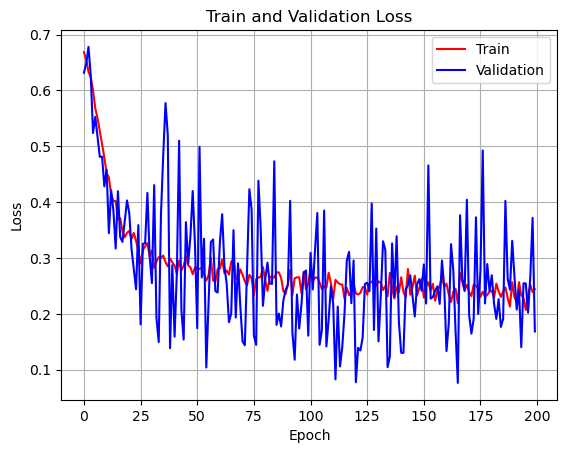

In [32]:
plt.plot(loss_train_hist, 'r-', label='Train')
plt.plot(loss_valid_hist, 'b-', label='Validation')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend();

## Plot accuracy

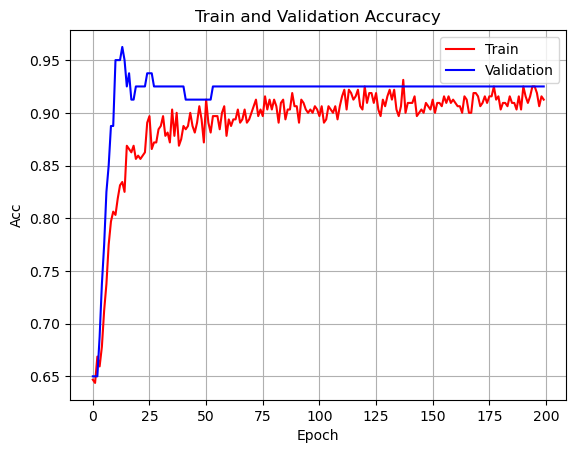

In [33]:
import matplotlib.pyplot as plt

plt.plot(acc_train_hist, 'r-', label='Train')
plt.plot(acc_valid_hist, 'b-', label='Validation')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()
plt.show()